In [17]:
import tensorflow as tf 
from tensorflow import keras
import os
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps, Image
import PIL
import numpy as np

In [18]:
#Check TF Version
tf.version.VERSION

'2.6.0'

In [19]:
#Check availability of GPU
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
input_dir = "Inputs"
label_dir = "Labels"

img_size = (256, 256)
num_classes = 1
batch_size = 4

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

label_img_paths = sorted(
    [
        os.path.join(label_dir, fname)
        for fname in os.listdir(label_dir)
        if fname.endswith(".png")
    ]
)

print("Number of samples:", len(input_img_paths))

Number of samples: 20


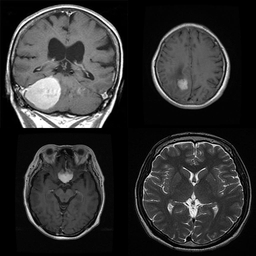

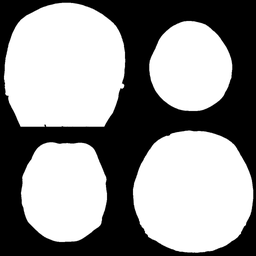

In [21]:
# Display input image #10
display(Image.open(input_img_paths[9]))

# Display level-set generated output mask
img = ImageOps.autocontrast(Image.open(label_img_paths[9]))
display(img)

In [22]:
#Batch generating data pipeline
class BrainMRI(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            tmp = np.expand_dims(img, 2)
            y[j] = np.where( tmp > 0, 1, 0)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1
        return x, y

In [23]:
new_model = tf.keras.models.load_model('brainMRI_segmentation.h5')

In [24]:
# Batch Generating Pipeline Call
test_gen = BrainMRI(batch_size, img_size, input_img_paths, input_img_paths)

In [25]:
%%time
# Generate predictions for all images in the validation set
val_preds = new_model.predict(test_gen)

Wall time: 1.72 s


In [26]:
def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

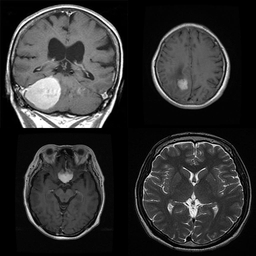

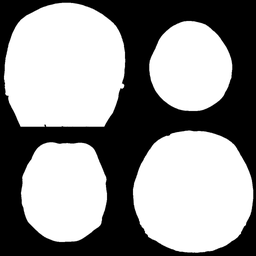

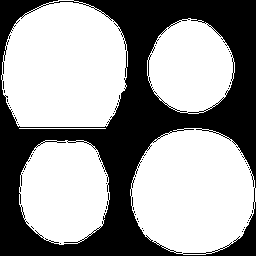

In [27]:
# Display results for test image #10
i = 9

# Display input image #10
display(Image.open(input_img_paths[9]))

# Display level-set generated output mask
img = ImageOps.autocontrast(Image.open(label_img_paths[9]))
display(img)

# Display mask predicted by our model
display_mask(i)  